In [1]:
import numpy as np
import matplotlib.pyplot as plt
import nltk
%matplotlib inline

# 1.Fetch 20Newsgroup Data

In [2]:
from sklearn.datasets import fetch_20newsgroups
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'),
                                  shuffle=True, random_state=11)
newsgroups_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'),
                                  shuffle=True, random_state=11)

In [3]:
print('Training text number:', len(newsgroups_train.data))
print('Testing text number:', len(newsgroups_test.data))

Training text number: 11314
Testing text number: 7532


In [4]:
index = 0
label = newsgroups_train.target[index]
print("Type:",newsgroups_train.target_names[label])
print('#' * 20)
print("\n".join(newsgroups_train.data[index].split("\n")))

Type: comp.windows.x
####################
--- Received from EEI.EEIIHY  353-1-2800455         93-04-26 12.28
  -> VAX.XPERT..EXPO.LCS.MIT.EDU..INET
  -: - - - - - - - - - - > MAIL USER IN VAX AND INTERNET
help




# 2.Preprocessing

In [5]:
#Remove extra blanks, punctuation, digits from original texts
import string
import re
def preProcessor(s):
    #s = s.encode('utf-8')

    #remove punctuation
    s = re.sub('['+string.punctuation+']', ' ', s)
    #remove digits
    s = re.sub('['+string.digits+']', ' ', s)
    #remove foreign characters
    s = re.sub('[^a-zA-Z]', ' ', s)
    #remove line ends
    s = re.sub('\n', ' ', s)
    #turn to lower case
    s = s.lower()
    #remove stopwords
    #for item in stopwords:
        #s = s.replace(item, ' ') 
    #remove extra blanks
    s = re.sub('[ ]+',' ', s)
    s = s.rstrip()

    #s = s.translate(string.punctuation)

    return s

In [6]:
preProcessor(newsgroups_train.data[0])

' received from eei eeiihy vax xpert expo lcs mit edu inet mail user in vax and internet help'

Preprocess each piece of news.

In [8]:
newsgroups_train.data = [preProcessor(item) for item in newsgroups_train.data]
newsgroups_test.data = [preProcessor(item) for item in newsgroups_test.data]

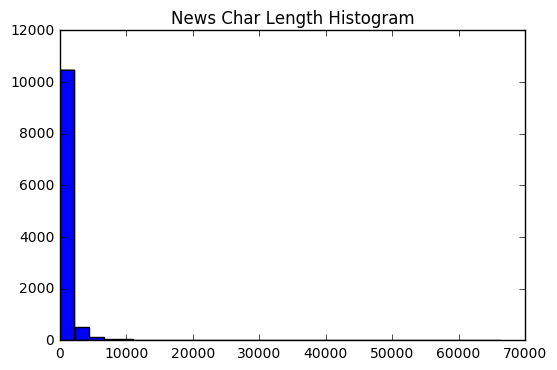

In [10]:
#Calculate the character lengths for each piece of news
char_lens =  [len(item) for item in newsgroups_train.data]
plt.hist(char_lens, bins=30)
plt.title('News Char Length Histogram')

Most news has a length of less than 5000 characters.

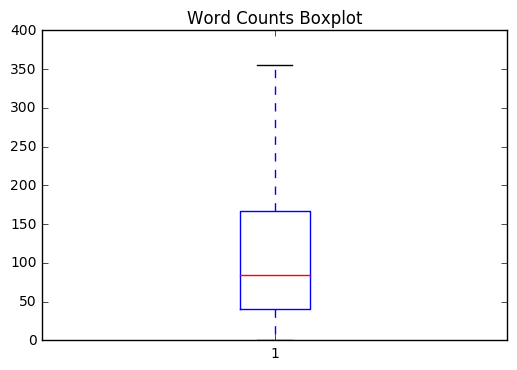

In [11]:
seq_len_train = [len(item.split()) for item in newsgroups_train.data]
seq_len_test = [len(item.split()) for item in newsgroups_test.data]
#Make a boxplot
plt.boxplot(seq_len_train, sym='')
plt.title('Word Counts Boxplot')

In [12]:
np.percentile(seq_len_train, [5, 25, 50, 95])

array([   9.,   41.,   84.,  567.])

The majority of news has less than 350 words. 

In [13]:
#Filter out those very long or very short news
train_data = []
train_label = []
test_data = []
test_label = []
for i, news in enumerate(newsgroups_train.data):
    if seq_len_train[i] > 10 and seq_len_train[i] < 400:
        train_data.append(news)
        train_label.append(newsgroups_train.target[i])
for i, news in enumerate(newsgroups_test.data):
    if seq_len_test[i] > 10 and seq_len_test[i] < 400:
        test_data.append(news)
        test_label.append(newsgroups_train.target[i])

## 3.Word2Vec Model

In [14]:
#import pandas
import tensorflow as tf
learn = tf.contrib.learn
from tensorflow.contrib.layers.python.layers import encoders
from tensorflow.contrib.learn.python.learn.estimators import model_fn as model_fn_lib

In [15]:
MAX_DOCUMENT_LENGTH = 400
EMBEDDING_SIZE = 50
n_words = 0

In [24]:
vocab_processor = learn.preprocessing.VocabularyProcessor(MAX_DOCUMENT_LENGTH, min_frequency=2)
x_train = np.array(list(vocab_processor.fit_transform(train_data)))
x_test = np.array(list(vocab_processor.transform(test_data)))
y_train = np.array(train_label)
y_test = np.array(test_label)
n_words = len(vocab_processor.vocabulary_)
print('Total words: %d' % n_words)

Total words: 17560


In [25]:
#Trim the lens, so the maximum lengs of each article is below MAX_DOCUMENT_LENGTH
seq_len_train_trim = [MAX_DOCUMENT_LENGTH if l>MAX_DOCUMENT_LENGTH else l for l in seq_len_train ]
seq_len_test_trim = [MAX_DOCUMENT_LENGTH if l>MAX_DOCUMENT_LENGTH else l for l in seq_len_test ]

In [26]:
x_train.shape

(9781, 400)

In [27]:
len(y_train)

9781

In [30]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.utils.np_utils import to_categorical

y_train = to_categorical(y_train, num_classes=20)
y_test = to_categorical(y_test, num_classes=20)

In [37]:
print('Build model...')
model = Sequential()
model.add(Embedding(n_words, EMBEDDING_SIZE))
model.add(LSTM(EMBEDDING_SIZE, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(50))
model.add(Dense(20, activation='softmax'))

# try using different optimizers and different optimizer configs
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
model.fit(x_train, y_train,
          batch_size=128,
          epochs=5,
          validation_data=(x_test, y_test))


Build model...
Train...
Train on 9781 samples, validate on 6501 samples
Epoch 1/5
9781/9781 [==============================] - 142s - loss: 2.9895 - acc: 0.0557 - val_loss: 2.9901 - val_acc: 0.0541
Epoch 2/5
9781/9781 [==============================] - 147s - loss: 2.9875 - acc: 0.0585 - val_loss: 2.9904 - val_acc: 0.0535
Epoch 3/5
9781/9781 [==============================] - 180s - loss: 2.9870 - acc: 0.0548 - val_loss: 2.9892 - val_acc: 0.0535
Epoch 4/5
9781/9781 [==============================] - 247s - loss: 2.9866 - acc: 0.0547 - val_loss: 2.9901 - val_acc: 0.0535
Epoch 5/5
9781/9781 [==============================] - 243s - loss: 2.9865 - acc: 0.0539 - val_loss: 2.9890 - val_acc: 0.0535


In [38]:
score, acc = model.evaluate(x_test, y_test,
                            batch_size=128)
print('Test score:', score)
print('Test accuracy:', acc)

6501/6501 [==============================] - 22s    
Test score: 2.98903480913
Test accuracy: 0.0535302261262


### Bag of Words Model

In [31]:
def bag_of_words_model(features, target, mode):
  """词袋子模型，将文章看成单词集合，忽视先后顺序"""   
  #one-hot转换
  target_1hot = tf.one_hot(indices=target, depth=20, on_value=1, off_value=0)
  #计算每篇文章的bow向量
  features = encoders.bow_encoder(
      features, vocab_size=n_words, embed_dim=EMBEDDING_SIZE)
  #全连接层
  logits = tf.contrib.layers.fully_connected(features, 20, activation_fn=None)
  #预测值
  predictions = tf.argmax(logits, 1)
  predictions_dict = {'class': predictions, 'prob': tf.nn.softmax(logits)}
  #损失函数
  loss = tf.contrib.losses.softmax_cross_entropy(logits, target_1hot)
  #额外的指标
  eval_metric_ops = {
      'accuracy': tf.metrics.accuracy(
          target, predictions)
  }

  train_op = tf.contrib.layers.optimize_loss(
      loss,
      tf.contrib.framework.get_global_step(),
      optimizer='Adam',
      learning_rate=0.01)
    
  result = model_fn_lib.ModelFnOps(
      mode=mode,
      predictions=predictions_dict,
      loss=loss,
      train_op=train_op,
      eval_metric_ops=eval_metric_ops)
  return result

In [32]:
model_fn = bag_of_words_model
classifier = learn.Estimator(model_fn=model_fn, model_dir='bow/')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_task_type': None, '_environment': 'local', '_task_id': 0, '_keep_checkpoint_every_n_hours': 10000, '_keep_checkpoint_max': 5, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000002CF85CEA470>, '_master': '', '_tf_random_seed': None, '_evaluation_master': '', '_is_chief': True, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_num_ps_replicas': 0}


In [33]:
#classifier.fit(x_train, y_train, steps=6)
# Instantiate Estimator
def get_train_inputs():
    x = tf.constant(x_train)
    y = tf.constant(y_train)
    return x, y

In [ ]:
# Fit
classifier.fit(input_fn=get_train_inputs, steps=300)

Instructions for updating:
Use tf.losses.softmax_cross_entropy instead.
Instructions for updating:
Use tf.losses.compute_weighted_loss instead.
Instructions for updating:
Use tf.losses.add_loss instead.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into bow/model.ckpt.


In [35]:
# Score accuracy
def get_test_inputs():
    x = tf.constant(x_test)
    y = tf.constant(y_test)
    return x, y


In [129]:
#y_predicted = [
    #p['class'] for p in classifier.predict(
        #x_test, as_iterable=True)]

ev = classifier.evaluate(input_fn=get_test_inputs, steps=1)

Instructions for updating:
Use tf.losses.softmax_cross_entropy instead.
Instructions for updating:
Use tf.losses.compute_weighted_loss instead.
Instructions for updating:
Use tf.losses.add_loss instead.
INFO:tensorflow:Starting evaluation at 2017-05-08-03:23:55
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2017-05-08-03:23:56
INFO:tensorflow:Saving dict for global step 300: accuracy = 0.830589, global_step = 300, loss = 0.629024


In [134]:
print('Classification Accuracy: ', round(ev['accuracy'], 4))

Classification Accuracy:  0.8306


In [128]:
#from sklearn import metrics
#score = metrics.accuracy_score(newsgroups_test.target, y_predicted)
#print('Accuracy: {0:f}'.format(score))

Accuracy: 0.830589


### RNN Model

In [54]:
#from tensorflow.contrib import rnn
def rnn_model(features, target, mode):
  """RNN model to predict from sequence of words to a class."""
  # Convert indexes of words into embeddings.
  # This creates embeddings matrix of [n_words, EMBEDDING_SIZE] and then
  # maps word indexes of the sequence into [batch_size, sequence_length,
  # EMBEDDING_SIZE].
  word_vectors = tf.contrib.layers.embed_sequence(
      features, vocab_size=n_words, embed_dim=EMBEDDING_SIZE, scope='words')

  # Split into list of embedding per word, while removing doc length dim.
  # word_list results to be a list of tensors [batch_size, EMBEDDING_SIZE].
  word_list = tf.unstack(word_vectors, axis=1)

  # Create a Gated Recurrent Unit cell with hidden size of EMBEDDING_SIZE.
  cell = tf.contrib.rnn.GRUCell(EMBEDDING_SIZE)
  
  if mode == tf.contrib.learn.ModeKeys.TRAIN:
     seqlen = tf.constant(seq_len_train_trim)
  else:
     seqlen = tf.constant(seq_len_test_trim)
  # Create an unrolled Recurrent Neural Networks to length of
  # MAX_DOCUMENT_LENGTH and passes word_list as inputs for each unit.
  #Use dynamic rnn by specifying sequence_length
  encoding, _ = tf.contrib.rnn.static_rnn(cell, word_list, dtype=tf.float32,
                                         sequence_length=seqlen)
    
  

  # Given encoding of RNN, take encoding of last step (e.g hidden size of the
  # neural network of last step) and pass it as features for logistic
  # regression over output classes.
  #print(encoding.shape)
  target_1hot = tf.one_hot(target, 20, 1, 0)
  logits = tf.contrib.layers.fully_connected(encoding[-1], 20, activation_fn=None)
  loss = tf.contrib.losses.softmax_cross_entropy(logits, target_1hot)


  #预测值
  predictions = tf.argmax(logits, 1)
  predictions_dict = {'class': predictions, 'prob': tf.nn.softmax(logits)}
  #额外的指标
  eval_metric_ops = {
      'accuracy': tf.metrics.accuracy(
          target, predictions)
  }

  # 训练参数设置
  train_op = tf.contrib.layers.optimize_loss(
      loss,
      tf.contrib.framework.get_global_step(),
      optimizer='Adam',
      learning_rate=0.01)
  #输出结果设置
  result = model_fn_lib.ModelFnOps(
      mode=mode,
      predictions=predictions_dict,
      loss=loss,
      train_op=train_op,
      eval_metric_ops=eval_metric_ops)

  return result


In [55]:
model_fn = rnn_model
classifier = learn.Estimator(model_fn=model_fn, model_dir='rnn/')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x13572d400>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_session_config': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': 'rnn/'}


In [56]:
# Instantiate Estimator
def get_train_inputs():
    x = tf.constant(x_train)
    y = tf.constant(y_train)
    return x, y

In [ ]:
#classifier.fit(x_train, y_train, steps=6)
 # Fit
classifier.fit(input_fn=get_train_inputs, steps=3)

Instructions for updating:
Use tf.losses.softmax_cross_entropy instead. Note that the order of the logits and labels arguments has been changed.
Instructions for updating:
Use tf.losses.compute_weighted_loss instead.
Instructions for updating:
Use tf.losses.add_loss instead.
INFO:tensorflow:Create CheckpointSaverHook.
Type is unsupported, or the types of the items don't match field type in CollectionDef.
'dict' object has no attribute 'name'


In [ ]:
ev = classifier.evaluate(input_fn=get_test_inputs, steps=1)

In [38]:
print('Accuracy: {0:f}'.format(ev['accuracy']))

Accuracy: 0.062268


In [61]:
#y_predicted = [
    #p['class'] for p in classifier.predict(
        #x_test, as_iterable=True)]
#score = metrics.accuracy_score(newsgroups_test.target, y_predicted)
#print('Accuracy: {0:f}'.format(score))

It seems that the recurrent neural network does not perform as well as bag-of-word model.

In [30]:
#from tensorflow.contrib import rnn
def birnn_model(features, target, mode):
  """RNN model to predict from sequence of words to a class."""
  # Convert indexes of words into embeddings.
  # This creates embeddings matrix of [n_words, EMBEDDING_SIZE] and then
  # maps word indexes of the sequence into [batch_size, sequence_length,
  # EMBEDDING_SIZE].
  word_vectors = tf.contrib.layers.embed_sequence(
      features, vocab_size=n_words, embed_dim=EMBEDDING_SIZE, scope='words')

  # Split into list of embedding per word, while removing doc length dim.
  # word_list results to be a list of tensors [batch_size, EMBEDDING_SIZE].
  word_list = tf.unstack(word_vectors, axis=1)

  #Forward direction cell
  lstm_fw_cell = tf.contrib.rnn.BasicLSTMCell(EMBEDDING_SIZE, forget_bias=1.0)
  # Backward direction cell
  lstm_bw_cell = tf.contrib.rnn.BasicLSTMCell(EMBEDDING_SIZE, forget_bias=1.0)
  
  if mode == tf.contrib.learn.ModeKeys.TRAIN:
     seqlen = tf.constant(seq_len_train_trim)
  else:
     seqlen = tf.constant(seq_len_test_trim)
  # Create an unrolled Recurrent Neural Networks to length of
  # MAX_DOCUMENT_LENGTH and passes word_list as inputs for each unit.
  #Use dynamic rnn by specifying sequence_length
  #_, encoding = tf.contrib.rnn.static_rnn(cell, word_list, dtype=tf.float32,
                                         #sequence_length=seqlen)
  encoding, _, _ = tf.contrib.rnn.static_bidirectional_rnn(lstm_fw_cell, 
                                               lstm_bw_cell, word_list, sequence_length=seqlen,
                                               dtype=tf.float32)
  #encoding = encoding[-1]

  # Given encoding of RNN, take encoding of last step (e.g hidden size of the
  # neural network of last step) and pass it as features for logistic
  # regression over output classes.
  target_1hot = tf.one_hot(target, 20, 1, 0)
  logits = tf.contrib.layers.fully_connected(encoding, 20, activation_fn=None)
  loss = tf.contrib.losses.softmax_cross_entropy(logits, target_1hot)


  #预测值
  predictions = tf.argmax(logits, 1)
  predictions_dict = {'class': predictions, 'prob': tf.nn.softmax(logits)}
  #额外的指标
  eval_metric_ops = {
      'accuracy': tf.metrics.accuracy(
          target, predictions)
  }

  # 训练参数设置
  train_op = tf.contrib.layers.optimize_loss(
      loss,
      tf.contrib.framework.get_global_step(),
      optimizer='Adam',
      learning_rate=0.01)
  #输出结果设置
  result = model_fn_lib.ModelFnOps(
      mode=mode,
      predictions=predictions_dict,
      loss=loss,
      train_op=train_op,
      eval_metric_ops=eval_metric_ops)

  return result



### CNN Model

In [28]:
N_FILTERS = 10
WINDOW_SIZE = 20
FILTER_SHAPE1 = [WINDOW_SIZE, EMBEDDING_SIZE]
FILTER_SHAPE2 = [WINDOW_SIZE, N_FILTERS]
POOLING_WINDOW = 4
POOLING_STRIDE = 2
def cnn_model(features, target, mode):
  """2 layer ConvNet to predict from sequence of words to a class."""
  # Convert indexes of words into embeddings.
  # This creates embeddings matrix of [n_words, EMBEDDING_SIZE] and then
  # maps word indexes of the sequence into [batch_size, sequence_length,
  # EMBEDDING_SIZE].
  target_1hot = tf.one_hot(target, 20, 1, 0)
  word_vectors = tf.contrib.layers.embed_sequence(
      features, vocab_size=n_words, embed_dim=EMBEDDING_SIZE, scope='words')
  word_vectors = tf.expand_dims(word_vectors, 3)
  with tf.variable_scope('CNN_Layer1'):
    # Apply Convolution filtering on input sequence.
    conv1 = tf.contrib.layers.convolution2d(
        word_vectors, N_FILTERS, FILTER_SHAPE1, padding='VALID')
    # Add a RELU for non linearity.
    conv1 = tf.nn.relu(conv1)
    # Max pooling across output of Convolution+Relu.
    pool1 = tf.nn.max_pool(
        conv1,
        ksize=[1, POOLING_WINDOW, 1, 1],
        strides=[1, POOLING_STRIDE, 1, 1],
        padding='SAME')
    # Transpose matrix so that n_filters from convolution becomes width.
    pool1 = tf.transpose(pool1, [0, 1, 3, 2])
  with tf.variable_scope('CNN_Layer2'):
    # Second level of convolution filtering.
    conv2 = tf.contrib.layers.convolution2d(
        pool1, N_FILTERS, FILTER_SHAPE2, padding='VALID')
    # Max across each filter to get useful features for classification.
    pool2 = tf.squeeze(tf.reduce_max(conv2, 1), squeeze_dims=[1])

  # Apply regular WX + B and classification.
  logits = tf.contrib.layers.fully_connected(pool2, 20, activation_fn=None)
  loss = tf.contrib.losses.softmax_cross_entropy(logits, target_1hot)

  #预测值
  predictions = tf.argmax(logits, 1)
  predictions_dict = {'class': predictions, 'prob': tf.nn.softmax(logits)}
  #额外的指标
  eval_metric_ops = {
      'accuracy': tf.metrics.accuracy(
          target, predictions)
  }

  # 训练参数设置
  train_op = tf.contrib.layers.optimize_loss(
      loss,
      tf.contrib.framework.get_global_step(),
      optimizer='Adam',
      learning_rate=0.01)
  #输出结果设置
  result = model_fn_lib.ModelFnOps(
      mode=mode,
      predictions=predictions_dict,
      loss=loss,
      train_op=train_op,
      eval_metric_ops=eval_metric_ops)

  return result


In [31]:
model_fn = cnn_model
classifier = learn.Estimator(model_fn=model_fn, model_dir='cnn/')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_master': '', '_save_checkpoints_secs': 600, '_is_chief': True, '_keep_checkpoint_every_n_hours': 10000, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_evaluation_master': '', '_environment': 'local', '_num_ps_replicas': 0, '_save_checkpoints_steps': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000000057DE8588>, '_tf_random_seed': None, '_save_summary_steps': 100, '_keep_checkpoint_max': 5, '_model_dir': None, '_num_worker_replicas': 0}


In [32]:
 # Fit
classifier.fit(input_fn=get_train_inputs, steps=3)

Instructions for updating:
Use tf.losses.softmax_cross_entropy instead. Note that the order of the logits and labels arguments has been changed.
Instructions for updating:
Use tf.losses.compute_weighted_loss instead.
Instructions for updating:
Use tf.losses.add_loss instead.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into cnn/model.ckpt.
INFO:tensorflow:loss = 2.99572, step = 1
INFO:tensorflow:Saving checkpoints for 3 into cnn/model.ckpt.
INFO:tensorflow:Loss for final step: 2.98689.


Estimator(params=None)

In [33]:
ev = classifier.evaluate(input_fn=get_test_inputs, steps=1)

Instructions for updating:
Use tf.losses.softmax_cross_entropy instead. Note that the order of the logits and labels arguments has been changed.
Instructions for updating:
Use tf.losses.compute_weighted_loss instead.
Instructions for updating:
Use tf.losses.add_loss instead.
INFO:tensorflow:Starting evaluation at 2017-05-08-13:50:50
INFO:tensorflow:Restoring parameters from cnn/model.ckpt-3
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2017-05-08-13:51:02
INFO:tensorflow:Saving dict for global step 3: accuracy = 0.0543016, global_step = 3, loss = 2.97413
